In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/linkedin-job-postings/postings.csv
/kaggle/input/linkedin-job-postings/companies/companies.csv
/kaggle/input/linkedin-job-postings/companies/company_industries.csv
/kaggle/input/linkedin-job-postings/companies/company_specialities.csv
/kaggle/input/linkedin-job-postings/companies/employee_counts.csv
/kaggle/input/linkedin-job-postings/mappings/industries.csv
/kaggle/input/linkedin-job-postings/mappings/skills.csv
/kaggle/input/linkedin-job-postings/jobs/benefits.csv
/kaggle/input/linkedin-job-postings/jobs/job_skills.csv
/kaggle/input/linkedin-job-postings/jobs/job_industries.csv
/kaggle/input/linkedin-job-postings/jobs/salaries.csv


In [2]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from transformers import BertTokenizer, BertModel, DataCollatorWithPadding, AdamW
from tqdm import tqdm
pd.set_option('display.max_columns', None)
from math import sqrt
import re
import numpy as np
tqdm.pandas()

In [3]:
def load_data(filepath):
    data = pd.read_csv(filepath)
    data = data.dropna(axis=0, subset='normalized_salary')
    data = data.dropna(axis=0, subset='description')
    data = data[data['pay_period']=='YEARLY']
    data = data[data['currency']=='USD']
    data.drop(['job_posting_url','original_listed_time',
              'compensation_type', 'company_id',
              'closed_time','remote_allowed','applies',
              'posting_domain','application_url',
              'fips','zip_code','min_salary','med_salary','max_salary',
              'formatted_work_type','views','job_id','expiry',
              'sponsored','listed_time','pay_period','currency','application_type'],axis=1,inplace=True)
    data = data[data['normalized_salary']>10000]
    return data

In [4]:
file_loc = '/kaggle/input/linkedin-job-postings/postings.csv'
df=load_data(file_loc)

In [19]:
# may remove later
# def extract_location_or_state(location):
#     # Use regex to match the state abbreviation after a comma
#     match = re.search(r',\s*([A-Za-z]{2})$', location)
    
#     if match:
#         # If state abbreviation is found, return the state
#         return match.group(1)
#     else:
#         # If no state abbreviation, return everything before the comma (if any)
#         return location.split(',')[0]

# # Apply the function to the 'location' column
# df['location'] = df['location'].apply(extract_location_or_state)

In [5]:
df.isna().sum()

company_name                    292
title                             0
description                       0
location                          0
formatted_experience_level     4949
skills_desc                   20056
work_type                         0
normalized_salary                 0
dtype: int64

In [7]:
# df[pd.isnull(df['formatted_experience_level'])]['description'][2]

In [6]:
df = df[
    df["description"].apply(lambda x: len(x) > 100)
]

In [7]:
df.replace(np.nan, '', regex=True, inplace=True)
df_f = pd.DataFrame()
df_f['info'] = (
    df['company_name'] + ' ' +
    df['title'] + ' ' +
    df['formatted_experience_level'] + ' ' +   # here is a change
    df['work_type'] + ' ' +                  # here is a change
    df['location'] + ' ' +
    df['skills_desc'] + ' ' +
    df['description']
)
df_f['normalized_salary'] = df['normalized_salary'].astype(int)

In [8]:
def clean_text(text: str) -> str:
    """Clean raw text string.

    Args:
        text (str): Raw text to clean.


    Returns:
        str: cleaned text.
    """
    # Lower
    text = text.lower()

    # Spacing and filters
    # text = re.sub(r'\([^)]*\)', '', text) # removing texts inside '(' and ')'
    # text = re.sub(r'\d+', '', text) # removing digits (may change later)
    text = re.sub(r'\*+', '', text)
    text = re.sub(r"http\S+", "", text) # removing websites
    text = re.sub(r'\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}', '', text)
    text = re.sub(r'\b\S+?@\S+?\.\S+?\b', '', text) # removing email address
    text = re.sub(r'\\n|\n',' ',text)
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white spaces

    return text

In [9]:
# file_loc = '/kaggle/input/linkedin-job-postings/postings.csv'
# df=load_data(file_loc)
# df.drop(['job_posting_url','original_listed_time',
#               'compensation_type', 'company_id',
#               'closed_time','remote_allowed','applies',
#               'posting_domain','application_url',
#               'fips','zip_code','min_salary','med_salary','max_salary',
#               'formatted_work_type','views','job_id','expiry',
#               'sponsored','listed_time','pay_period','currency','application_type'],axis=1,inplace=True)
# df.replace(np.nan, '', regex=True, inplace=True)
# df_f = pd.DataFrame()
# df_f['info'] = (
#     df['company_name'] + ' ' +
#     df['title'] + ' ' +
#     df['location'] + ' ' +
#     df['skills_desc'] + ' ' +
#     df['formatted_experience_level'] + ' ' +
#     df['work_type'] + ' ' +
#     df['description']
# )
# df_f['normalized_salary'] = df['normalized_salary'].astype(int)

In [10]:
df_f['info'] = df_f['info'].progress_apply(clean_text)

100%|██████████| 20193/20193 [00:18<00:00, 1099.00it/s]


In [11]:
Q1 = df_f['normalized_salary'].quantile(0.25)
Q3 = df_f['normalized_salary'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range
filter = (df_f['normalized_salary'] >= Q1 - 1.5 * IQR) & (df_f['normalized_salary'] <= Q3 + 1.5 *IQR)
df_f = df_f[filter]

In [12]:
df_f['normalized_salary'].min(), df_f['normalized_salary'].max()

(10500, 245500)

In [13]:
print(df_f.shape)
df_f.to_csv('df_f.csv', index=False)

(19479, 2)


# new pre pro

In [16]:
# Q1 = df['normalized_salary'].quantile(0.25)
# Q3 = df['normalized_salary'].quantile(0.75)
# IQR = Q3 - Q1    #IQR is interquartile range
# filter = (df['normalized_salary'] >= Q1 - 1.5 * IQR) & (df['normalized_salary'] <= Q3 + 1.5 *IQR)
# df = df[filter]

In [17]:
# df_f = pd.DataFrame()
# df_f['info'] = (
#     df['company_name'] + ' ' + '[SEP]' + ' ' +
#     df['title'] + ' ' + '[SEP]' + ' ' +
#     df['location'] + ' ' + '[SEP]' + ' ' +
#     df['formatted_experience_level'] + ' ' + '[SEP]' + ' ' +
#     df['work_type'] + ' ' + '[SEP]' + ' ' +
#     df['description']
# )
# df_f['normalized_salary'] = df['normalized_salary']

## Load and tokenize data


In [14]:
def load_data_clean(file_loc):
    data = pd.read_csv(file_loc)
    return data

def preprocess_data(texts, labels, tokenizer, max_len):
    """Tokenizes text data using a tokenizer."""
    inputs = tokenizer(
        texts,
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors="pt"
    )
    return inputs, torch.tensor(labels)

## Dataclass for handling text and labels

In [15]:
class TextDataset(Dataset):
    """Custom Dataset class for loading tokenized text and labels."""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32)
        return item

    def __len__(self):
        return len(self.labels)

## Prepare dataloaders with train, val, and test splits

In [16]:
def prepare_dataloaders(data, tokenizer, max_len, train_batch_size,
                        val_batch_size, test_batch_size, 
                        test_size=0.2, val_size=0.1, seed=42):
    # Split data with fixed random_state for reproducibility
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=seed)
    train_data, val_data = train_test_split(train_data, test_size=val_size, random_state=seed)

    # Apply log transformation
    train_data['normalized_salary'] = np.log1p(train_data['normalized_salary'])
    val_data['normalized_salary'] = np.log1p(val_data['normalized_salary'])
    test_data['normalized_salary'] = np.log1p(test_data['normalized_salary'])

    # Tokenize data
    train_inputs, train_labels = preprocess_data(train_data["info"].tolist(), train_data["normalized_salary"].tolist(), tokenizer, max_len)
    val_inputs, val_labels = preprocess_data(val_data["info"].tolist(), val_data["normalized_salary"].tolist(), tokenizer, max_len)
    test_inputs, test_labels = preprocess_data(test_data["info"].tolist(), test_data["normalized_salary"].tolist(), tokenizer, max_len)

    # Create datasets
    train_dataset = TextDataset(train_inputs, train_labels)
    val_dataset = TextDataset(val_inputs, val_labels)
    test_dataset = TextDataset(test_inputs, test_labels)

    # Data collator for dynamic padding
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=data_collator)
    val_loader = DataLoader(val_dataset, batch_size=val_batch_size, collate_fn=data_collator)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, collate_fn=data_collator)

    return train_loader, val_loader, test_loader

## Define the model for regression

In [17]:
class BERTRegression(nn.Module):
    def __init__(self, model_name="bert-base-uncased"):
        super(BERTRegression, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.pooler_output
        return self.regressor(last_hidden_state)

## Training function

In [18]:
def train_model(model, train_loader, val_loader, epochs, learning_rate,criterion, save_path, device):
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = evaluate_model(model, val_loader, criterion, device)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print(f"Validation loss improved to {best_val_loss:.6f}. Saving model...")
            torch.save(model.state_dict(), save_path)  # Save the model state_dict
        
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

## Evaluate on validation

In [19]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
            outputs_exp = torch.expm1(outputs)
            labels_exp = torch.expm1(labels)

            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(data_loader)

## Test on test

In [20]:
def test_model(model, test_loader, device):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    predictions = np.expm1(predictions)
    actuals = np.expm1(actuals)

    rmse = sqrt(mean_squared_error(actuals, predictions))
    print(f"Test RMSE: {rmse:.6f}")

    return predictions, actuals

## Main function

In [21]:
def set_seeds(seed: int = 42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# def main():
set_seeds(42)  # Set seeds for reproducibility

filepath = '/kaggle/working/df_f.csv'
model_name = 'bert-base-uncased'
max_len = 512
train_batch_size = 16
val_batch_size = 32
test_batch_size = 32
epochs = 6
learning_rate = 0.5e-5
criterion = nn.HuberLoss(delta=1.0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path = '/kaggle/working/bert_final.pth'

# Load data
data = load_data_clean(filepath)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Prepare dataloaders
train_loader, val_loader, test_loader = prepare_dataloaders(data, tokenizer, max_len, 
                                                            train_batch_size, val_batch_size,
                                                            test_batch_size, seed=42)

# Initialize and train model
model = BERTRegression(model_name).to(device)
train_model(model, train_loader, val_loader, epochs, learning_rate, criterion, save_path, device)

# Evaluate on test dataset
# pred,act = test_model(model, test_loader, device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1:   0%|          | 0/877 [00:00<?, ?it/s]/tmp/ipykernel_30/3267916010.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_30/3267916010.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32)
Training Epoch 1: 100%|

Validation loss improved to 0.114137. Saving model...
Epoch 1 | Train Loss: 1.938499 | Val Loss: 0.114137


Training Epoch 2: 100%|██████████| 877/877 [12:38<00:00,  1.16it/s]


Validation loss improved to 0.105130. Saving model...
Epoch 2 | Train Loss: 0.069183 | Val Loss: 0.105130


Training Epoch 3: 100%|██████████| 877/877 [12:38<00:00,  1.16it/s]


Validation loss improved to 0.054617. Saving model...
Epoch 3 | Train Loss: 0.045287 | Val Loss: 0.054617


Training Epoch 4: 100%|██████████| 877/877 [12:39<00:00,  1.15it/s]


Validation loss improved to 0.034233. Saving model...
Epoch 4 | Train Loss: 0.036959 | Val Loss: 0.034233


Training Epoch 5: 100%|██████████| 877/877 [12:39<00:00,  1.15it/s]


Epoch 5 | Train Loss: 0.031738 | Val Loss: 0.052586


Training Epoch 6: 100%|██████████| 877/877 [12:39<00:00,  1.15it/s]


Epoch 6 | Train Loss: 0.027861 | Val Loss: 0.046532


In [22]:
def load_model(model_class, model_name, save_path, device):
    # Recreate the model
    model = model_class(model_name)
    # Load the saved state dict into the model, mapping the model to the correct device
    model.load_state_dict(torch.load(save_path, map_location=device))
    # Explicitly move the model to the desired device
    model.to(device)  # Add this line
    model.eval()  # Set model to evaluation mode
    return model

# Load the saved model for inference
loaded_model = load_model(BERTRegression, "bert-base-uncased", "/kaggle/working/bert_final.pth", device)


/tmp/ipykernel_30/2425195137.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=device))


In [23]:
# latest
pred1, act1 = test_model(loaded_model, test_loader, device)

/tmp/ipykernel_30/3267916010.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_30/3267916010.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32)


Test RMSE: 28541.888935


In [24]:
## save the tokenier

save_directory = '/kaggle/working/'
tokenizer.save_pretrained(save_directory)

('/kaggle/working/tokenizer_config.json',
 '/kaggle/working/special_tokens_map.json',
 '/kaggle/working/vocab.txt',
 '/kaggle/working/added_tokens.json')

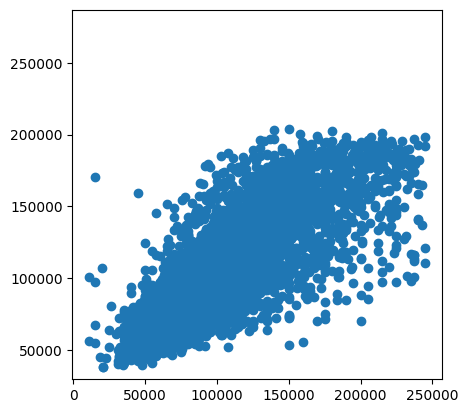

In [30]:
# latest
from matplotlib import pyplot as plt

results = pd.DataFrame({
    "Actual": act1,
    "Prediction": pred1
})

results['diff'] = results['Prediction'] - results['Actual']
results['abs_diff'] = abs(results['Prediction'] - results['Actual'])

plt.scatter(results['Actual'],results['Prediction'])
plt.axis('square')
plt.show()



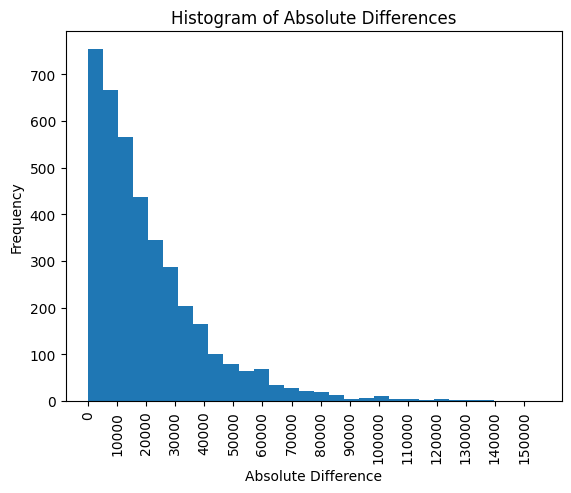

In [39]:
import matplotlib.pyplot as plt

# Plot the histogram
ax = results['abs_diff'].plot(kind='hist', bins=30)  # Adjust 'bins' as needed

# Set custom x-axis ticks
ticks = range(0, int(results['abs_diff'].max()) + 10, 10000)  # Adjust step as needed
plt.xticks(ticks)
plt.xticks(rotation=90) 
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Absolute Differences')

plt.show()

In [27]:
results['Actual'].corr(results['Prediction'])

0.7805915778621771

In [ ]:
results_df = pd.DataFrame({
    "Actual": act,
    "Prediction": pred
})

with pd.option_context('display.max_rows', None):
    print(results_df)

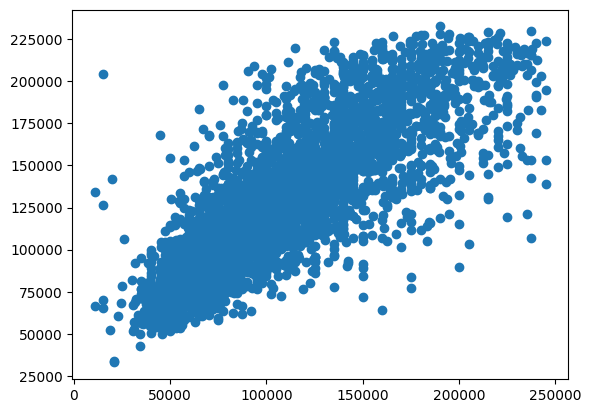

In [57]:
from matplotlib import pyplot as plt
results_df_cpy = results_df.copy()
results_df_cpy['diff'] = abs(results_df_cpy['Actual']-results_df_cpy['Prediction'])
# with pd.option_context('display.max_rows', None):
#     print(results_df_cpy)
plt.scatter(results_df_cpy['Actual'],results_df_cpy['Prediction'])
plt.show()

In [58]:
results_df_cpy['Actual'].corr(results_df_cpy['Prediction'])

0.8034396673255569

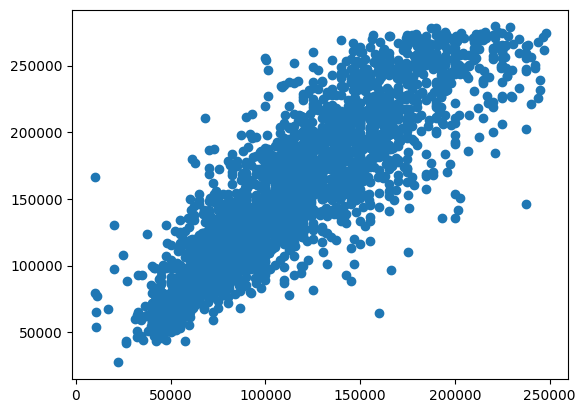

In [26]:
from matplotlib import pyplot as plt
results_df_cpy = results_df.copy()
results_df_cpy['diff'] = abs(results_df_cpy['Actual']-results_df_cpy['Prediction'])
# with pd.option_context('display.max_rows', None):
#     print(results_df_cpy)
plt.scatter(results_df_cpy['Actual'],results_df_cpy['Prediction'])
plt.show()

<Axes: ylabel='Frequency'>

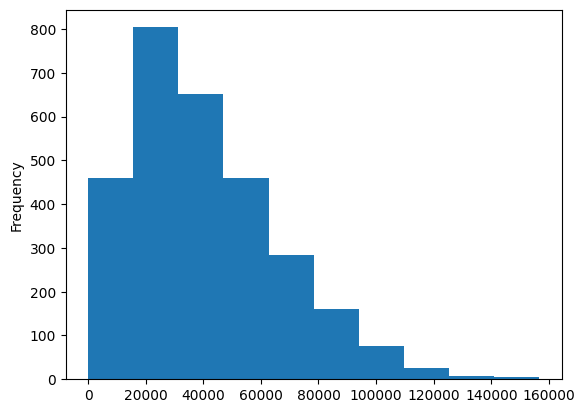

In [30]:
results_df_cpy['diff'].plot(kind='hist')

In [27]:
results_df_cpy['Actual'].corr(results_df_cpy['Prediction'])

0.8748930692989759

In [40]:
results_df_cpy[results_df_cpy['diff']>50000].shape

(914, 3)

In [28]:
for i in range(0,250000+1, 1000):
    print(i,results_df_cpy[results_df_cpy['Actual']>i]['Actual'] \
    .corr(results_df_cpy[results_df_cpy['Actual']>i]['Prediction']))

0 0.8748930692989759
1000 0.8748930692989759
2000 0.8748930692989759
3000 0.8748930692989759
4000 0.8748930692989759
5000 0.8748930692989759
6000 0.8748930692989759
7000 0.8748930692989759
8000 0.8748930692989759
9000 0.8748930692989759
10000 0.8748930692989759
11000 0.8757094594829463
12000 0.8757094594829463
13000 0.8757094594829463
14000 0.8757094594829463
15000 0.8757094594829463
16000 0.8757094594829463
17000 0.875639319104899
18000 0.875639319104899
19000 0.875639319104899
20000 0.875639319104899
21000 0.8761149813434826
22000 0.8761149813434826
23000 0.8759419321127898
24000 0.8759419321127898
25000 0.8760812333303861
26000 0.8760812333303861
27000 0.8757809236963234
28000 0.8757829902641818
29000 0.8757829902641818
30000 0.8757829902641818
31000 0.8757829902641818
32000 0.8756689683465584
33000 0.8749507931660574
34000 0.8749507931660574
35000 0.8746983701065377
36000 0.8745673620069354
37000 0.8743619059348541
38000 0.8743163464649418
39000 0.8741939048711664
40000 0.873157825

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [84]:
with pd.option_context('display.max_rows', None):
    print(results_df_cpy[results_df_cpy['Actual']<15000])

results_df_cpy[results_df_cpy['Actual']>10000].shape

(3898, 3)

In [73]:
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

def test_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    # Apply exponential transformation
    predictions = np.expm1(predictions)
    actuals = np.expm1(actuals)

    # Filter only where actuals > 50,000
    filtered_predictions = [pred for pred, act in zip(predictions, actuals) if act > 15000]
    filtered_actuals = [act for act in actuals if act > 15000]

    # Check if there are enough values to calculate metrics
    if len(filtered_actuals) > 0:
        mse = sqrt(mean_squared_error(filtered_actuals, filtered_predictions))
        print(f"Test MSE (for actuals > 15,000): {mse:.6f}")
    else:
        print("No actual values greater than 50,000 found in the test set.")

    return filtered_predictions, filtered_actuals

In [74]:
fil_pred, fil_actual = test_model(model,test_loader)

/tmp/ipykernel_31/3267916010.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_31/3267916010.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32)


Test MSE (for actuals > 15,000): 35416.420147


In [ ]:
def save_model_state(model, path = "/kaggle/working/model/model_weights_0.pth"):
    torch.save(model.state_dict(), path)

save_model_state(model)
tokenizer.save_pretrained('/kaggle/working/')

# # To reload
# define the class again
# model = BERTRegression("bert-base-uncased")  # Initialize the architecture
# model.load_state_dict(torch.load("path/to/model_weights.pth"))
# model.eval()  # Set to evaluation mode

## Set device and run the main

In [30]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# main()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1:   0%|          | 0/897 [00:00<?, ?it/s]/tmp/ipykernel_30/3267916010.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_30/3267916010.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32)
Training Epoch 1: 100%|

Epoch 1 | Train Loss: 7.150934 | Val Loss: 1.269279


Training Epoch 2: 100%|██████████| 897/897 [22:30<00:00,  1.51s/it]


Epoch 2 | Train Loss: 1.324997 | Val Loss: 1.035661


Training Epoch 3: 100%|██████████| 897/897 [22:30<00:00,  1.51s/it]


Epoch 3 | Train Loss: 0.988715 | Val Loss: 0.866264


Training Epoch 4: 100%|██████████| 897/897 [22:30<00:00,  1.51s/it]


Epoch 4 | Train Loss: 0.703608 | Val Loss: 0.802620


Training Epoch 5: 100%|██████████| 897/897 [22:30<00:00,  1.51s/it]


Epoch 5 | Train Loss: 0.525938 | Val Loss: 0.787952


Training Epoch 6: 100%|██████████| 897/897 [22:31<00:00,  1.51s/it]


Epoch 6 | Train Loss: 0.387472 | Val Loss: 0.779615


Training Epoch 7: 100%|██████████| 897/897 [22:30<00:00,  1.51s/it]


Epoch 7 | Train Loss: 0.323104 | Val Loss: 0.798440


Training Epoch 8: 100%|██████████| 897/897 [22:30<00:00,  1.51s/it]


Epoch 8 | Train Loss: 0.277470 | Val Loss: 0.730692
Test MSE: 1479018880.000000
